In [12]:
import os
import time
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [13]:
# Crear carpeta temporal Spark
temp_path = os.path.join(os.getcwd(), 'spark-temp')
os.makedirs(temp_path, exist_ok=True)

# Definir variables de entorno
os.environ['JAVA_HOME'] = os.environ['CONDA_PREFIX'] + '\Library'
os.environ['SPARK_LOCAL_DIRS'] = temp_path

print('JAVA_HOME:', os.environ.get('JAVA_HOME'))
print('SPARK_LOCAL_DIRS:', os.environ.get('SPARK_LOCAL_DIRS'))

JAVA_HOME: C:\Users\TESTER\anaconda3\envs\btc_portfolio\Library
SPARK_LOCAL_DIRS: C:\Users\TESTER\Desktop\Laboral\GIT\btc-3-asset-portfolio-extension\notebooks\spark-temp


In [14]:
# Crear Spark Session y medir tiempo
start_time = time.time()

spark = SparkSession.builder \
.appName('btcproject') \
.config('spark.driver.memory', '8g') \
.config('spark.executor.memory', '8g') \
.config('spark.local.dir', temp_path) \
.getOrCreate()

spark.sparkContext.setLogLevel('ERROR')

end_time = time.time()
print('Spark Version:', spark.version)
print(f'Tiempo total en crear SparkSession: {round(end_time - start_time, 2)} segundos')

Spark Version: 3.5.4
Tiempo total en crear SparkSession: 1.5 segundos


In [17]:
final_df_extended = pd.read_csv("../data/final_df_extended.csv")

print("Rows:", final_df_extended.shape[0])
print("Columns:", final_df_extended.shape[1])
print(final_df_extended.info())
display(final_df_extended.head(5))


Rows: 125
Columns: 16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          125 non-null    object 
 1   close_btc      125 non-null    float64
 2   high_btc       125 non-null    float64
 3   low_btc        125 non-null    float64
 4   volume_btc     125 non-null    float64
 5   marketcap_btc  125 non-null    float64
 6   close_sp500    125 non-null    float64
 7   high_sp500     125 non-null    float64
 8   low_sp500      125 non-null    float64
 9   volume_sp500   125 non-null    int64  
 10  open_gold      125 non-null    float64
 11  high_gold      125 non-null    float64
 12  low_gold       125 non-null    float64
 13  close_gold     125 non-null    float64
 14  volume_gold    125 non-null    int64  
 15  avg_cpi        125 non-null    float64
dtypes: float64(13), int64(2), object(1)
memory usage: 15.8+ KB
None


,month,close_btc,high_btc,low_btc,volume_btc,marketcap_btc,close_sp500,high_sp500,low_sp500,volume_sp500,open_gold,high_gold,low_gold,close_gold,volume_gold,avg_cpi
0,2014-10-01,386.944000,493.928009,372.239990,34707300.0,5.158621e+09,168.495575,168.629265,167.751942,146903000,1171.04,1172.88,1170.79,1171.52,146,100.91037
1,2014-11-01,338.321014,411.697998,289.295990,12545400.0,4.549893e+09,173.124466,173.684278,172.882164,57890100,1168.73,1168.94,1165.73,1165.88,551,100.72039
2,2014-12-01,378.046997,457.092987,320.626007,9194440.0,5.125958e+09,172.685318,174.911735,172.559300,130333800,1186.62,1186.93,1186.52,1186.83,94,100.40971
3,2015-01-01,320.192993,384.037994,304.231995,13942900.0,4.377511e+09,167.568771,169.853992,167.299929,197729700,1283.08,1283.58,1282.86,1283.56,108,99.77007
4,2015-02-01,217.464005,320.434998,171.509995,23348200.0,2.997692e+09,176.986877,177.759818,176.936470,108076000,1212.96,1213.04,1212.49,1212.78,175,100.02295


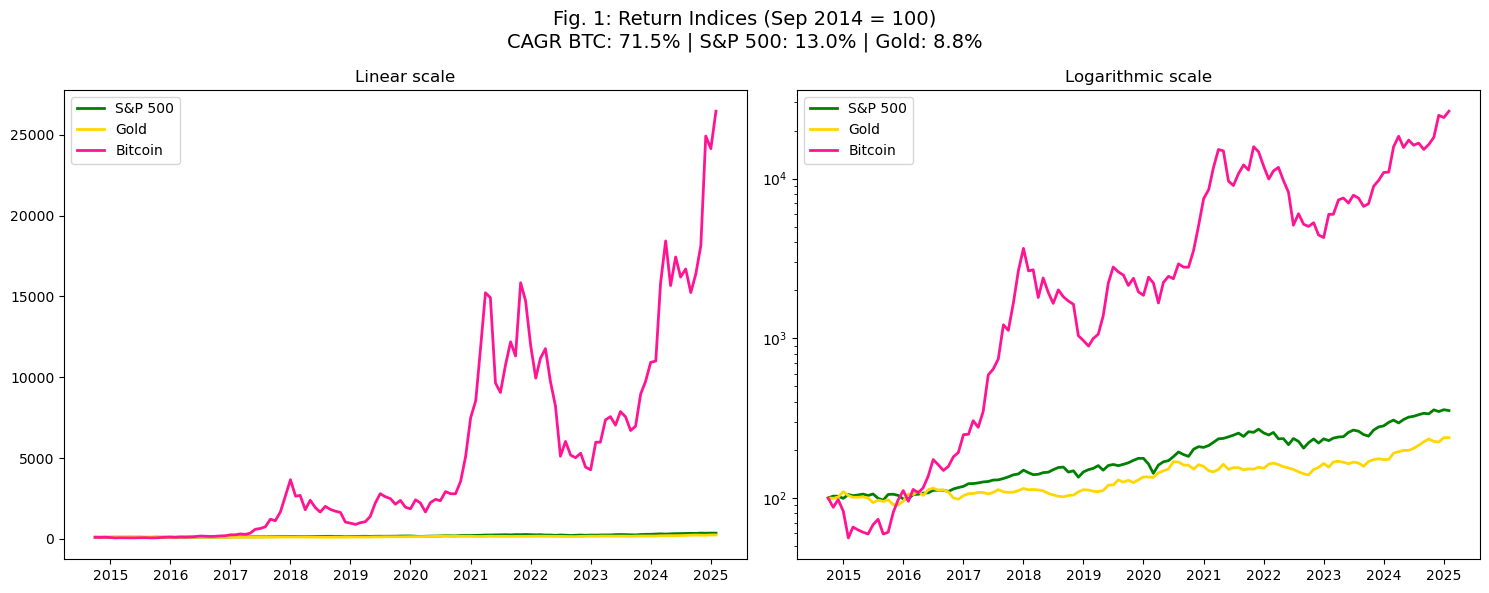

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure month is datetime
final_df_extended['month'] = pd.to_datetime(final_df_extended['month'])

# Create Return Index Base Sep 2014 = 100
def create_return_index(series):
    return series / series.iloc[0] * 100

btc_idx = create_return_index(final_df_extended['close_btc'])
sp500_idx = create_return_index(final_df_extended['close_sp500'])
gold_idx = create_return_index(final_df_extended['close_gold'])

# Calculate CAGR
years = (final_df_extended['month'].iloc[-1] - final_df_extended['month'].iloc[0]).days / 365.25

def calculate_cagr(start, end, years):
    return (end / start) ** (1 / years) - 1

cagr_btc = calculate_cagr(final_df_extended['close_btc'].iloc[0], final_df_extended['close_btc'].iloc[-1], years)
cagr_sp500 = calculate_cagr(final_df_extended['close_sp500'].iloc[0], final_df_extended['close_sp500'].iloc[-1], years)
cagr_gold = calculate_cagr(final_df_extended['close_gold'].iloc[0], final_df_extended['close_gold'].iloc[-1], years)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

color_btc = 'deeppink'
color_sp500 = 'green'
color_gold = 'gold'

# Linear Scale
axes[0].plot(final_df_extended['month'], sp500_idx, label='S&P 500', color=color_sp500, linewidth=2)
axes[0].plot(final_df_extended['month'], gold_idx, label='Gold', color=color_gold, linewidth=2)
axes[0].plot(final_df_extended['month'], btc_idx, label='Bitcoin', color=color_btc, linewidth=2)
axes[0].set_title('Linear scale')
axes[0].legend()

# Log Scale
axes[1].plot(final_df_extended['month'], sp500_idx, label='S&P 500', color=color_sp500, linewidth=2)
axes[1].plot(final_df_extended['month'], gold_idx, label='Gold', color=color_gold, linewidth=2)
axes[1].plot(final_df_extended['month'], btc_idx, label='Bitcoin', color=color_btc, linewidth=2)
axes[1].set_yscale('log')
axes[1].set_title('Logarithmic scale')
axes[1].legend()

# Show years in x-axis
for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle(f'Fig. 1: Return Indices (Sep 2014 = 100)\n'
             f'CAGR BTC: {cagr_btc:.1%} | S&P 500: {cagr_sp500:.1%} | Gold: {cagr_gold:.1%}',
             fontsize=14)

plt.tight_layout()
plt.show()


In [11]:
btc_vol = final_df_extended['avg_volume_btc']
sp500_vol = final_df_extended['avg_volume_sp500']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(final_df_extended['month'], sp500_vol, label='S&P 500', color='green', linewidth=2)
axes[0].plot(final_df_extended['month'], btc_vol, label='Bitcoin', color='deeppink', linewidth=2)
axes[0].set_title('Linear scale')
axes[0].legend()

axes[1].plot(final_df_extended['month'], sp500_vol, label='S&P 500', color='green', linewidth=2)
axes[1].plot(final_df_extended['month'], btc_vol, label='Bitcoin', color='deeppink', linewidth=2)
axes[1].set_yscale('log')
axes[1].set_title('Logarithmic scale')
axes[1].legend()

for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('Fig. 2: S&P 500 & Bitcoin daily trading volumes', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/figure_2.png', dpi=300)
plt.show()


KeyError: 'avg_volume_btc'

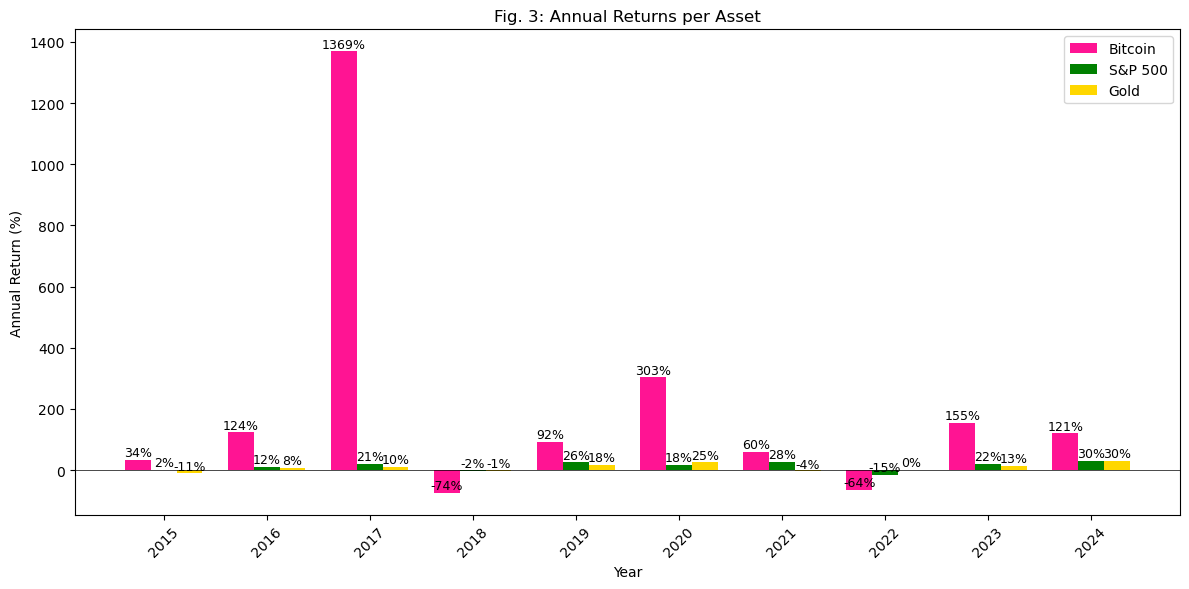

In [8]:
final_df_extended['year'] = final_df_extended['month'].dt.year

annual_prices = final_df_extended.groupby('year').agg({
    'avg_close_btc': 'last',
    'avg_close_sp500': 'last',
    'avg_price_gold': 'last'
})

annual_returns = annual_prices.pct_change() * 100
annual_returns = annual_returns.dropna().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

width = 0.25
x = annual_returns['year']

btc = annual_returns['avg_close_btc']
sp500 = annual_returns['avg_close_sp500']
gold = annual_returns['avg_price_gold']

ax.bar(x - width, btc, width=width, label='Bitcoin', color='deeppink')
ax.bar(x, sp500, width=width, label='S&P 500', color='green')
ax.bar(x + width, gold, width=width, label='Gold', color='gold')

ax.axhline(0, color='black', linewidth=0.5)

for i in range(len(x)):
    ax.text(x[i] - width, btc.iloc[i] + 2, f"{btc.iloc[i]:.0f}%", ha='center', va='bottom', fontsize=9)
    ax.text(x[i], sp500.iloc[i] + 2, f"{sp500.iloc[i]:.0f}%", ha='center', va='bottom', fontsize=9)
    ax.text(x[i] + width, gold.iloc[i] + 2, f"{gold.iloc[i]:.0f}%", ha='center', va='bottom', fontsize=9)

ax.set_title('Fig. 3: Annual Returns per Asset')
ax.set_xlabel('Year')
ax.set_ylabel('Annual Return (%)')
ax.legend()
plt.xticks(x, rotation=45)

plt.tight_layout()
plt.savefig('../figures/figure_3.png', dpi=300)
plt.show()


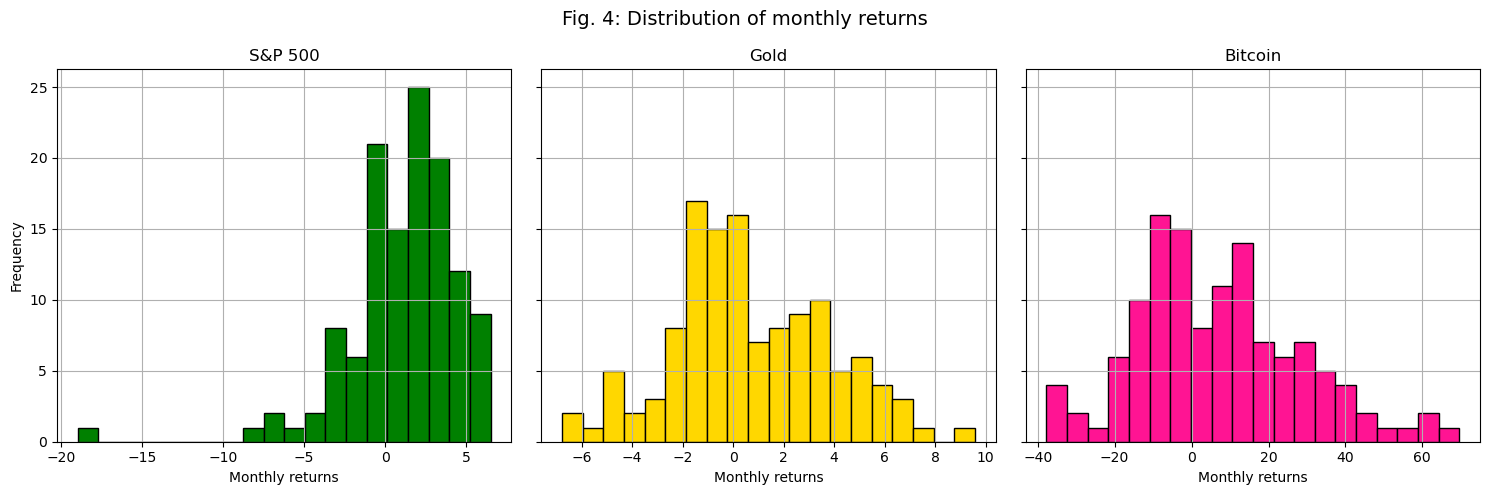

In [9]:
returns = final_df_extended[['avg_close_btc', 'avg_close_sp500', 'avg_price_gold']].pct_change().dropna() * 100

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

colors = {
    'avg_close_sp500': 'green',
    'avg_price_gold': 'gold',
    'avg_close_btc': 'deeppink'
}

assets = {
    'avg_close_sp500': 'S&P 500',
    'avg_price_gold': 'Gold',
    'avg_close_btc': 'Bitcoin'
}

bins = 20

for ax, col in zip(axes, assets.keys()):
    ax.hist(returns[col], bins=bins, color=colors[col], edgecolor='black')
    ax.set_title(assets[col])
    ax.set_xlabel('Monthly returns')
    ax.grid(True)

axes[0].set_ylabel('Frequency')

fig.suptitle('Fig. 4: Distribution of monthly returns', fontsize=14)

plt.tight_layout()
plt.savefig('../figures/figure_4.png', dpi=300)
plt.show()


In [13]:
import numpy as np
import pandas as pd

returns = final_df_extended[['avg_close_btc', 'avg_close_sp500', 'avg_price_gold']].pct_change().dropna()

years = (final_df_extended['month'].iloc[-1] - final_df_extended['month'].iloc[0]).days / 365.25

def annual_return(series):
    return ((series.iloc[-1] / series.iloc[0]) ** (1 / years) - 1) * 100

def annual_volatility(series):
    return series.std() * np.sqrt(12) * 100

def sharpe_ratio(series):
    return (series.mean() / series.std()) * np.sqrt(12)

def max_drawdown(series):
    roll_max = series.cummax()
    drawdown = (series / roll_max - 1) * 100
    return drawdown.min()

def var_95(series):
    return np.percentile(series, 5) * 100

def cvar_5(series):
    return series[series <= np.percentile(series, 5)].mean() * 100

summary_extended = pd.DataFrame({
    'S&P 500': [
        annual_return(final_df_extended['avg_close_sp500']),
        annual_volatility(returns['avg_close_sp500']),
        sharpe_ratio(returns['avg_close_sp500']),
        max_drawdown(final_df_extended['avg_close_sp500']),
        -33.9,  # manual (daily SP500)
        var_95(returns['avg_close_sp500']),
        cvar_5(returns['avg_close_sp500'])
    ],
    'Gold': [
        annual_return(final_df_extended['avg_price_gold']),
        annual_volatility(returns['avg_price_gold']),
        sharpe_ratio(returns['avg_price_gold']),
        max_drawdown(final_df_extended['avg_price_gold']),
        np.nan,
        var_95(returns['avg_price_gold']),
        cvar_5(returns['avg_price_gold'])
    ],
    'Bitcoin': [
        annual_return(final_df_extended['avg_close_btc']),
        annual_volatility(returns['avg_close_btc']),
        sharpe_ratio(returns['avg_close_btc']),
        max_drawdown(final_df_extended['avg_close_btc']),
        -83,  # manual (daily BTC)
        var_95(returns['avg_close_btc']),
        cvar_5(returns['avg_close_btc'])
    ]
}, index=[
    'Annual return (in %)',
    'Annual volatility (in %)',
    'Sharpe ratio',
    'Max. drawdown (monthly, in %)',
    'Max. drawdown (daily, in %)',
    'VaR(95) (in %)',
    'CVaR(5) (in %)'
])

summary_extended = summary_extended.round(1)

# Export to CSV
summary_extended.to_csv('../figures/figure_5_summary_stats.csv', index=True)

# Mostrar bonito
display(summary_extended.style.set_caption('Fig. 5: Asset class summary statistics (Extended Data)'))


,S&P 500,Gold,Bitcoin
Annual return (in %),13.300000,7.700000,70.800000
Annual volatility (in %),11.800000,10.800000,74.700000
Sharpe ratio,1.100000,0.700000,1.100000
"Max. drawdown (monthly, in %)",-19.300000,-15.500000,-75.600000
"Max. drawdown (daily, in %)",-33.900000,nan,-83.000000
VaR(95) (in %),-3.800000,-4.600000,-24.500000
CVaR(5) (in %),-7.800000,-5.300000,-32.500000


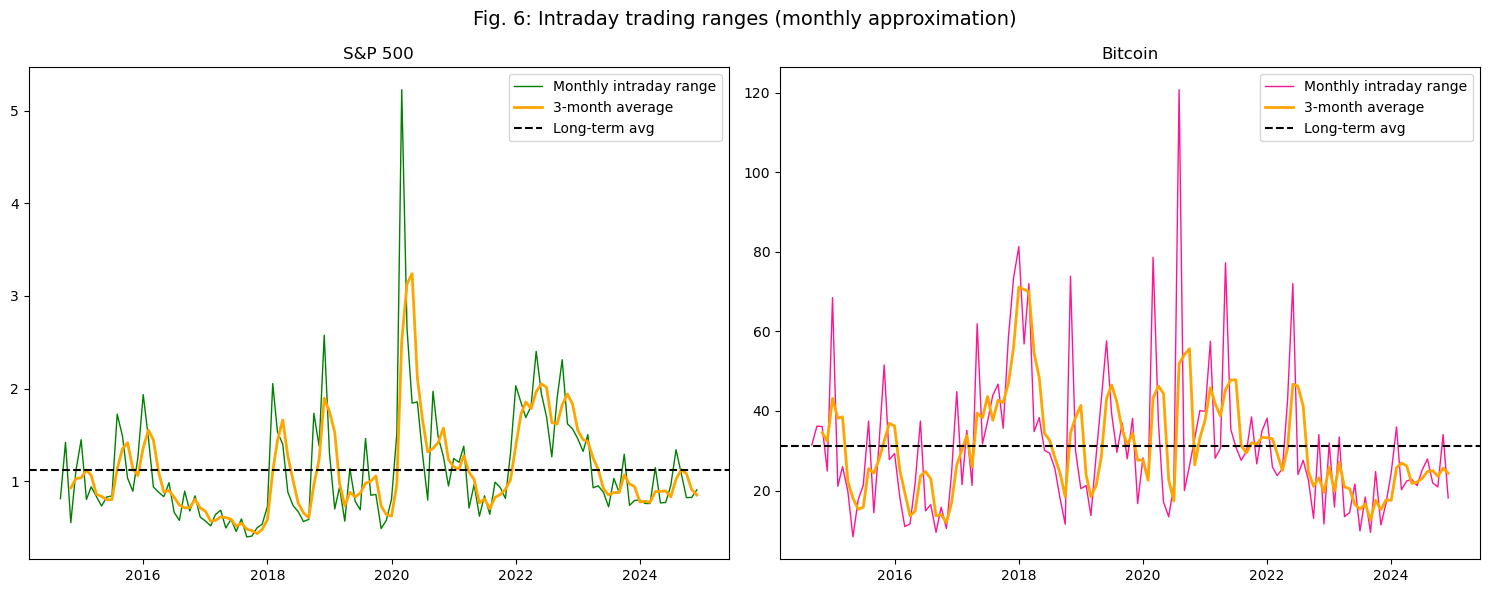

In [12]:
btc_range = (final_df_extended['avg_high_btc'] - final_df_extended['avg_low_btc']) / final_df_extended['avg_close_btc'] * 100
sp500_range = (final_df_extended['avg_high_sp500'] - final_df_extended['avg_low_sp500']) / final_df_extended['avg_close_sp500'] * 100

btc_roll = btc_range.rolling(3).mean()
sp500_roll = sp500_range.rolling(3).mean()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(final_df_extended['month'], sp500_range, label='Monthly intraday range', color='green', linewidth=1)
axes[0].plot(final_df_extended['month'], sp500_roll, label='3-month average', color='orange', linewidth=2)
axes[0].axhline(sp500_range.mean(), label='Long-term avg', color='black', linestyle='--')
axes[0].set_title('S&P 500')
axes[0].legend()

axes[1].plot(final_df_extended['month'], btc_range, label='Monthly intraday range', color='deeppink', linewidth=1)
axes[1].plot(final_df_extended['month'], btc_roll, label='3-month average', color='orange', linewidth=2)
axes[1].axhline(btc_range.mean(), label='Long-term avg', color='black', linestyle='--')
axes[1].set_title('Bitcoin')
axes[1].legend()

fig.suptitle('Fig. 6: Intraday trading ranges (monthly approximation)', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/figure_6.png', dpi=300)
plt.show()


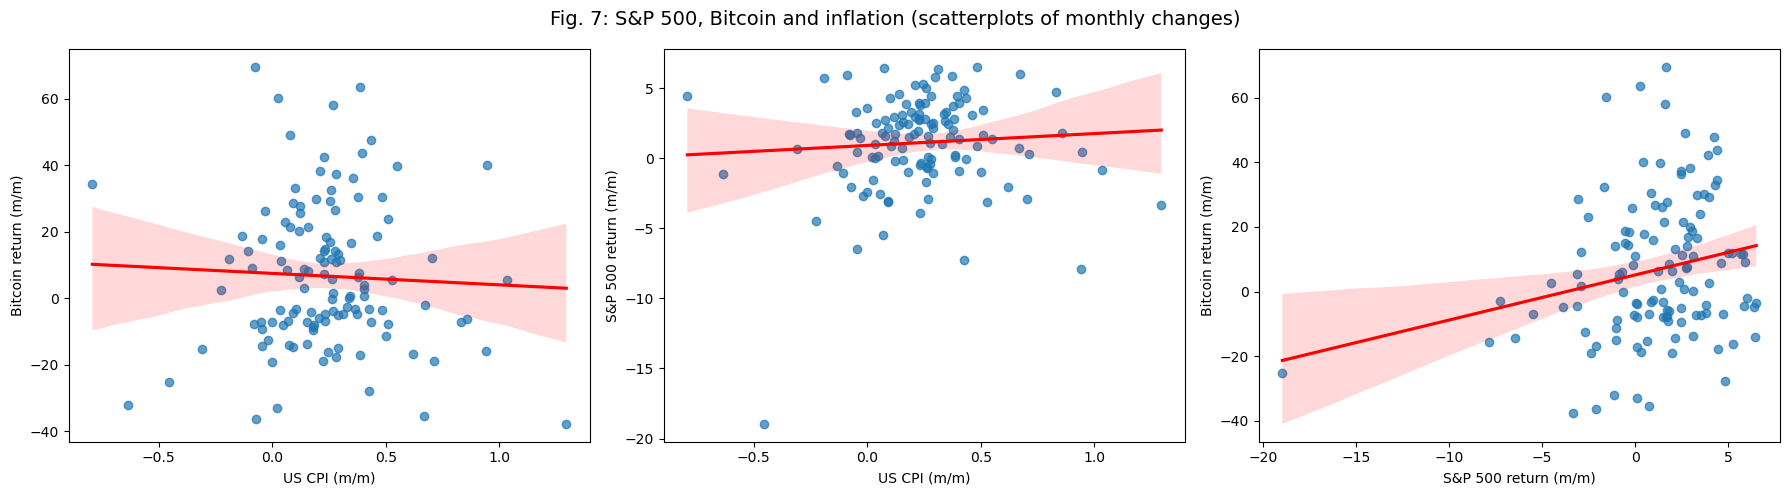

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

returns = final_df_extended[['avg_close_btc', 'avg_close_sp500', 'avg_price_gold', 'avg_cpi']].pct_change().dropna() * 100
returns['cpi_return'] = returns['avg_cpi']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.regplot(x='cpi_return', y='avg_close_btc', data=returns, ax=axes[0], scatter_kws={'alpha':0.7}, line_kws={"color":"red"})
axes[0].set_xlabel('US CPI (m/m)')
axes[0].set_ylabel('Bitcoin return (m/m)')

sns.regplot(x='cpi_return', y='avg_close_sp500', data=returns, ax=axes[1], scatter_kws={'alpha':0.7}, line_kws={"color":"red"})
axes[1].set_xlabel('US CPI (m/m)')
axes[1].set_ylabel('S&P 500 return (m/m)')

sns.regplot(x='avg_close_sp500', y='avg_close_btc', data=returns, ax=axes[2], scatter_kws={'alpha':0.7}, line_kws={"color":"red"})
axes[2].set_xlabel('S&P 500 return (m/m)')
axes[2].set_ylabel('Bitcoin return (m/m)')

fig.suptitle('Fig. 7: S&P 500, Bitcoin and inflation (scatterplots of monthly changes)', fontsize=14)

plt.tight_layout()
plt.savefig('../figures/figure_7.png', dpi=300)
plt.show()


In [15]:
corr_extended = returns[['avg_close_sp500', 'avg_price_gold', 'avg_close_btc', 'cpi_return']].corr()

corr_extended.index = ['S&P 500', 'Gold', 'Bitcoin', 'US CPI']
corr_extended.columns = ['S&P 500', 'Gold', 'Bitcoin', 'US CPI']

corr_extended = corr_extended.round(2)

corr_extended.to_csv('../figures/figure_8_correlation.csv', index=True)

display(corr_extended.style.set_caption('Fig. 8: Correlation coefficients (Extended Data)'))


,S&P 500,Gold,Bitcoin,US CPI
S&P 500,1.000000,0.110000,0.220000,0.070000
Gold,0.110000,1.000000,-0.090000,-0.070000
Bitcoin,0.220000,-0.090000,1.000000,-0.050000
US CPI,0.070000,-0.070000,-0.050000,1.000000


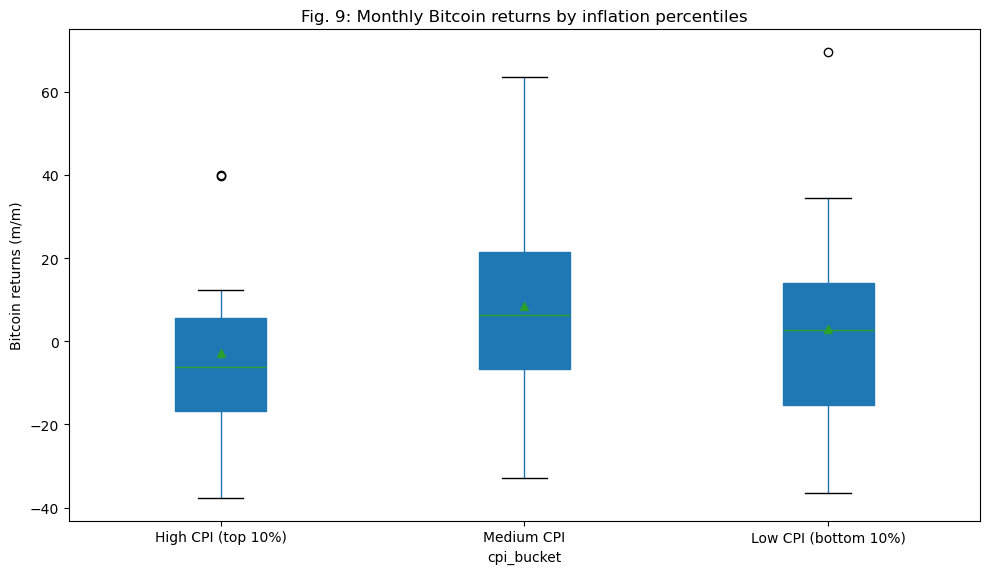

In [16]:
returns['cpi_bucket'] = pd.qcut(
    returns['cpi_return'],
    q=[0, 0.1, 0.9, 1],
    labels=['Low CPI (bottom 10%)', 'Medium CPI', 'High CPI (top 10%)']
)

category_order = ['High CPI (top 10%)', 'Medium CPI', 'Low CPI (bottom 10%)']
returns['cpi_bucket'] = pd.Categorical(returns['cpi_bucket'], categories=category_order, ordered=True)

fig, ax = plt.subplots(figsize=(10, 6))

returns.boxplot(column='avg_close_btc', by='cpi_bucket', ax=ax, grid=False, patch_artist=True, showmeans=True)

ax.set_title('Fig. 9: Monthly Bitcoin returns by inflation percentiles')
ax.set_ylabel('Bitcoin returns (m/m)')
plt.suptitle('')

plt.tight_layout()
plt.savefig('../figures/figure_9.png', dpi=300)
plt.show()
